In [1]:
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import dates as mpl_dates
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

datasource = pq.read_table("escooter_history.parquet")

dataset = datasource.to_pandas()
print(dataset)

                   datetime  holiday  workingday            weather   temp  \
0       2019-01-01 00:00:09        0           0  clear, few clouds   9.84   
1       2019-01-01 00:00:41        0           0  clear, few clouds   9.84   
2       2019-01-01 00:01:20        0           0  clear, few clouds   9.84   
3       2019-01-01 00:04:12        0           0  clear, few clouds   9.84   
4       2019-01-01 00:15:19        0           0  clear, few clouds   9.84   
...                     ...      ...         ...                ...    ...   
3296016 2020-12-31 23:55:56        0           1  clear, few clouds  10.66   
3296017 2020-12-31 23:55:59        0           1  clear, few clouds  10.66   
3296018 2020-12-31 23:57:17        0           1  clear, few clouds  10.66   
3296019 2020-12-31 23:57:28        0           1  clear, few clouds  10.66   
3296020 2020-12-31 23:58:10        0           1  clear, few clouds  10.66   

          atemp  humidity  windspeed  registered_customer  
0  

In [2]:
dataset.shape

(3296021, 9)


# Werte liegen nicht atomar vor, weitere aufsplittung nicht möglich

In [3]:
newcols = pd.get_dummies(dataset["weather"])
print(newcols)

         clear, few clouds  cloudy, mist  \
0                        1             0   
1                        1             0   
2                        1             0   
3                        1             0   
4                        1             0   
...                    ...           ...   
3296016                  1             0   
3296017                  1             0   
3296018                  1             0   
3296019                  1             0   
3296020                  1             0   

         heacy rain or thunderstorm or snow or ice pallets  \
0                                                        0   
1                                                        0   
2                                                        0   
3                                                        0   
4                                                        0   
...                                                    ...   
3296016                              

In [4]:
dataset = dataset.drop(columns=['weather'])
print(dataset)

                   datetime  holiday  workingday   temp   atemp  humidity  \
0       2019-01-01 00:00:09        0           0   9.84  14.395        81   
1       2019-01-01 00:00:41        0           0   9.84  14.395        81   
2       2019-01-01 00:01:20        0           0   9.84  14.395        81   
3       2019-01-01 00:04:12        0           0   9.84  14.395        81   
4       2019-01-01 00:15:19        0           0   9.84  14.395        81   
...                     ...      ...         ...    ...     ...       ...   
3296016 2020-12-31 23:55:56        0           1  10.66  13.635        65   
3296017 2020-12-31 23:55:59        0           1  10.66  13.635        65   
3296018 2020-12-31 23:57:17        0           1  10.66  13.635        65   
3296019 2020-12-31 23:57:28        0           1  10.66  13.635        65   
3296020 2020-12-31 23:58:10        0           1  10.66  13.635        65   

         windspeed  registered_customer  
0           0.0000               

In [5]:
dataset = dataset.join(newcols)
print(dataset)

                   datetime  holiday  workingday   temp   atemp  humidity  \
0       2019-01-01 00:00:09        0           0   9.84  14.395        81   
1       2019-01-01 00:00:41        0           0   9.84  14.395        81   
2       2019-01-01 00:01:20        0           0   9.84  14.395        81   
3       2019-01-01 00:04:12        0           0   9.84  14.395        81   
4       2019-01-01 00:15:19        0           0   9.84  14.395        81   
...                     ...      ...         ...    ...     ...       ...   
3296016 2020-12-31 23:55:56        0           1  10.66  13.635        65   
3296017 2020-12-31 23:55:59        0           1  10.66  13.635        65   
3296018 2020-12-31 23:57:17        0           1  10.66  13.635        65   
3296019 2020-12-31 23:57:28        0           1  10.66  13.635        65   
3296020 2020-12-31 23:58:10        0           1  10.66  13.635        65   

         windspeed  registered_customer  clear, few clouds  cloudy, mist  \

In [6]:
dataset = dataset.rename(columns={'heacy rain or thunderstorm or snow or ice pallets' : 'Heavy Precipitation', 'light snow or rain or thunderstorm': 'Light Precipitation'})

In [7]:
dataset.dtypes
dataset[['holiday', 'workingday' ]] = dataset[['holiday', 'workingday']].replace({0:False, 1:True})

In [8]:
dataset.dtypes

datetime               datetime64[ns]
holiday                          bool
workingday                       bool
temp                          float64
atemp                         float64
humidity                        int64
windspeed                     float64
registered_customer           boolean
clear, few clouds               uint8
cloudy, mist                    uint8
Heavy Precipitation             uint8
Light Precipitation             uint8
dtype: object

In [9]:
#Remove rows with Value 0 in Humidty
subset = dataset.loc[dataset["humidity"] == 0]
subset.shape
dataset = dataset[dataset.humidity!= 0]

(623, 12)

In [10]:
dataset['Dates'] = pd.to_datetime(dataset['datetime']).dt.date
dataset['Time'] = pd.to_datetime(dataset['datetime']).dt.time

dataset['Weekday'] = pd.to_datetime(dataset['datetime']).dt.day_name()
   


# Comparison between Weekdays

<ipython-input-11-d125c93d8c6d>:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  weekfig.set_xticklabels((weekdayset.index), Rotation=80)


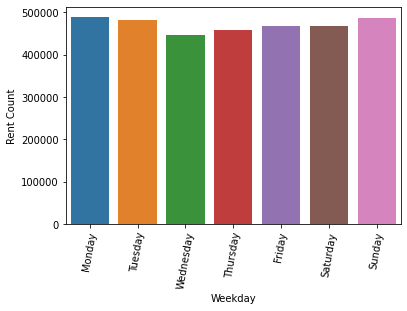

In [11]:
orderlist = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekdayset = dataset.groupby(["Weekday"]).size().to_frame("Rent Count").reindex(orderlist)
weekfig = sns.barplot(data=weekdayset, x=weekdayset.index, y="Rent Count")
weekfig.set_xticklabels((weekdayset.index), Rotation=80)
plt.show(weekfig)

# Montag, Verleih nach Zeiten

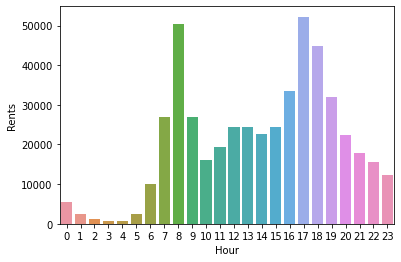

In [12]:
mondayset = dataset.loc[dataset["Weekday"]=="Monday"]
mondayhour = mondayset.groupby(mondayset.datetime.dt.hour).size().to_frame("Rents per Hour")
monfig = sns.barplot(data=mondayhour, x=mondayhour.index, y="Rents per Hour")
plt.xlabel("Hour")
plt.ylabel("Rents")
plt.show(monfig)

# Dienstag, Verleih nach Zeiten

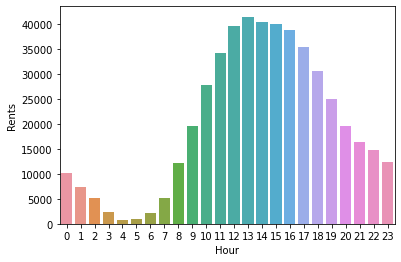

In [13]:
tuesdayset = dataset.loc[dataset["Weekday"]=="Tuesday"]
tuesdayhour = tuesdayset.groupby(tuesdayset.datetime.dt.hour).size().to_frame("Rents per Hour")
tuesfig = sns.barplot(data=tuesdayhour, x=tuesdayhour.index, y="Rents per Hour")
plt.xlabel("Hour")
plt.ylabel("Rents")
plt.show(tuesfig)

# Mittwoch, Verleih nach Zeiten

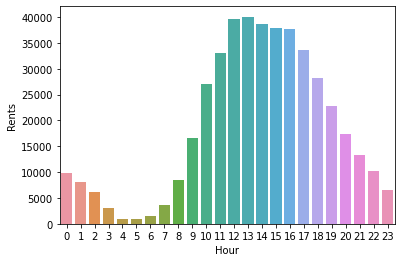

In [14]:
wednesdayset = dataset.loc[dataset["Weekday"]=="Wednesday"]
wednesdayhour = wednesdayset.groupby(wednesdayset.datetime.dt.hour).size().to_frame("Rents per Hour")
wedfig = sns.barplot(data=wednesdayhour, x=wednesdayhour.index, y="Rents per Hour")
plt.xlabel("Hour")
plt.ylabel("Rents")
plt.show(wedfig)

# Donnerstag, Verleih nach Zeiten

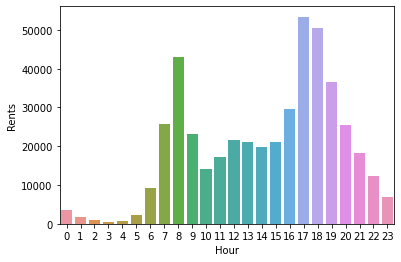

In [15]:
thursdayset = dataset.loc[dataset["Weekday"]=="Thursday"]
thursdayhour = thursdayset.groupby(thursdayset.datetime.dt.hour).size().to_frame("Rents per Hour")
thursfig = sns.barplot(data=thursdayhour, x=thursdayhour.index, y="Rents per Hour")
plt.xlabel("Hour")
plt.ylabel("Rents")
plt.show(thursfig)

# Freitag, Verleih nach Zeiten

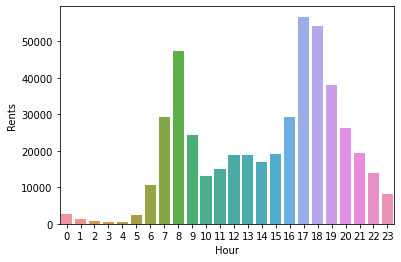

In [16]:
fridayset = dataset.loc[dataset["Weekday"]=="Friday"]
fridayhour = fridayset.groupby(fridayset.datetime.dt.hour).size().to_frame("Rents per Hour")
fridfig = sns.barplot(data=fridayhour, x=fridayhour.index, y="Rents per Hour")
plt.xlabel("Hour")
plt.ylabel("Rents")
plt.show(fridfig)

# Samstag, Verleih nach Zeiten

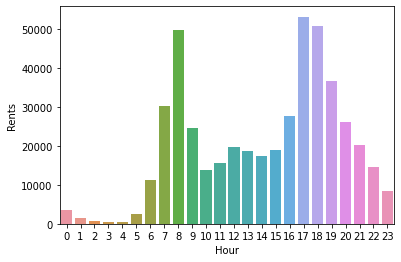

In [17]:
saturdayset = dataset.loc[dataset["Weekday"]=="Saturday"]
saturdayhour = saturdayset.groupby(saturdayset.datetime.dt.hour).size().to_frame("Rents per Hour")
satfig = sns.barplot(data=saturdayhour, x=saturdayhour.index, y="Rents per Hour")
plt.xlabel("Hour")
plt.ylabel("Rents")
plt.show(satfig)


# Sonntag, Verleih nach Zeiten

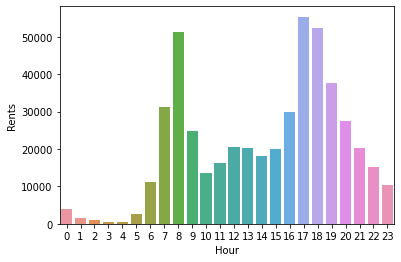

In [18]:
sundayset = dataset.loc[dataset["Weekday"]=="Sunday"]
sundayhour = sundayset.groupby(sundayset.datetime.dt.hour).size().to_frame("Rents per Hour")
sunfig = sns.barplot(data=sundayhour, x=sundayhour.index, y="Rents per Hour")
plt.xlabel("Hour")
plt.ylabel("Rents")
plt.show(sunfig)

# Ausleihen nach Monat und registrierten Kunden

<ipython-input-19-9e88a0c10ced>:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  monthfig.set_xticklabels((groupedbymonth.MonthYear), Rotation=80)


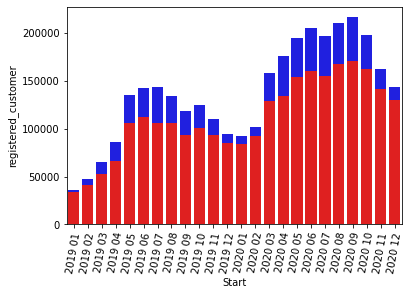

In [19]:
groupedbymonth = dataset.groupby(by=[dataset.datetime.dt.year, dataset.datetime.dt.month]).agg({'temp' : 'count', 'datetime': 'min', 'registered_customer' : 'sum'})
groupedbymonth = groupedbymonth.rename(columns={'temp' : 'Rents', 'datetime' : 'Start'})
groupedbymonth['MonthYear'] = groupedbymonth.Start.dt.strftime("%Y %m")
monthfig = sns.barplot(data=groupedbymonth, x=groupedbymonth["Start"], y="Rents", color='b')
monthfig = sns.barplot(data=groupedbymonth, x=groupedbymonth["Start"], y="registered_customer", color='r')
monthfig.set_xticklabels((groupedbymonth.MonthYear), Rotation=80)
plt.show(monthfig)